# UCL Dementia Research Institute Bioinformatician test

This notebook documents an example data analysis for the UCL Dementia Research Institute (DRI) Bioinformatician test.

*In general, I'll keep comments in the code to small notes, and keep the longer explanations in these markdown cells.*

## Data

As per the test specifications, there are two data groups, A and B, and here, the aim is to determine the difference(s) (if any) between them. Naturally, some exploratory analysis will follow, but here is a short description of the data and the rationale for making it:

The main grouping, A and B, is qualitative, and here, I am supposing that the treatment in question is some sort of drug trial to treat a disease — group A is a placebo, and group B is treated with the drug. The dependent variable is continuous, and is a measure of survival, in years (fractions of years are permissible). 

In both groups, besides participant survival, there are these additional data:
- Blood biomarker, which we will imagine has previously been to be associated with survival in this disease.
- Image biomarker, which is suspected to also be informative as to survival.
- Age of participants, the age of participants at the start of the trial. 

More information will be given on what the data look like, how it is created, and why, going through this notebook. 

## Methodology

*Spoiler Alert!* I will use multiple linear regression to ascertain the differences between groups A and B, whilst also considering:
- The distribution of the survival data.
- Multicollinearity between independent variables.
- Interactions between variables that affect survival. 

There will be more details on why and how these are done, going through. 

The aim of the regression analysis is to test the null hypothesis that there is no relationship between the independent variables (group, biomarkers, and age) and the dependent variable, survival.

In [62]:
# Imports
import numpy as np
import pandas as pd
import scipy.stats as ss
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns

# Generating survival data
In the block below, the survival data for both groups is generated. A skewed normal distribution is created for each treatment, with different characteristics (different skew and mean, but same standard deviation), 100 samples for each. The skew was added to allow addressing whether this affects the distribution of residuals, later on in the analysis (if time allows).

The distributions are then concatenated, and the A/B grouping is data is also generated to match. Here, rather than A or B, I use just a zero and one. Later, these will be added to dataframe to keep everything organised.

The plots show first, a histogram of the generated survival data, split by group — the skew is evident here. And the second plot is a simple scatter plot of survival plotted against group. 

So, here, examining the distributions, we might expect that the drug treatment, in group B, is having an effect on the survival of study participants. Before going any further, I will generate the rest of the data. 

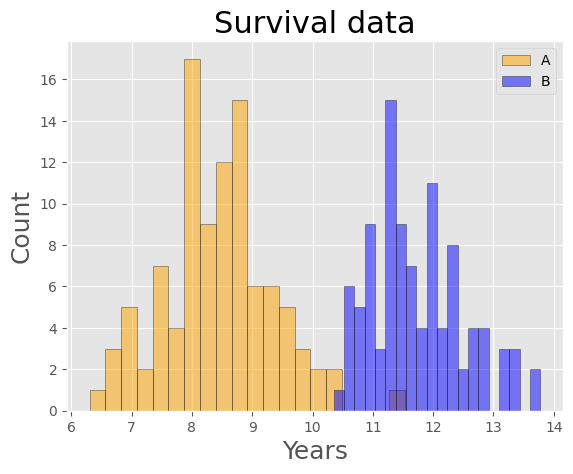

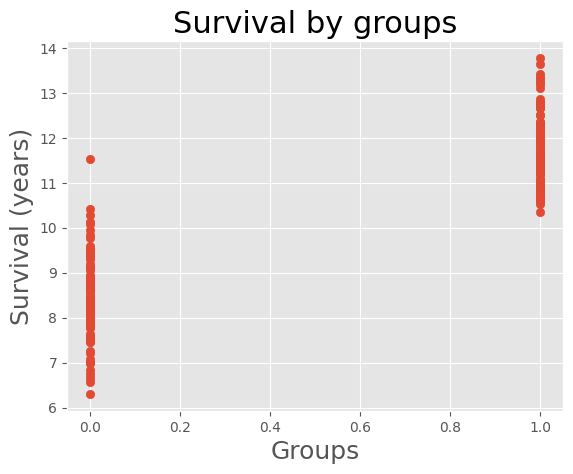

In [63]:
# set up the skewed distributions
rnd_state = 2 # for the random number generator, so that the data will be consistent
mean_a = 9
mean_b = 11
skew_level_a = -1
skew_level_b = 2
survival_a = ss.skewnorm.rvs(skew_level_a, loc=mean_a, size=100, random_state=rnd_state)
survival_b = ss.skewnorm.rvs(skew_level_b, loc=mean_b, size=100, random_state=rnd_state)

# put the distributions into one vector
survival = np.concatenate((survival_a, survival_b))

# create the A/B grouping data (int for now)
groups = np.zeros((200,), dtype=int)
groups[100:] = 1

# plot a histogram of the data
plt.style.use('ggplot')
plt.hist(survival_a, bins=20, edgecolor='black', color='orange', alpha=0.5)
plt.hist(survival_b, bins=20, edgecolor='black', color='blue', alpha=0.5)
plt.title("Survival data", fontsize = 22)
plt.legend(labels=['A', 'B'])
plt.xlabel("Years", fontsize=18)
plt.ylabel("Count", fontsize=18)
plt.show()

# plot a scatter plot of the data
plt.scatter(groups, survival)
plt.title("Survival by groups", fontsize = 22)
plt.xlabel("Groups", fontsize=18)
plt.ylabel("Survival (years)", fontsize=18)
plt.show()

# Generating biomarker data
In the block below, both datasets for the biomarkers are genrated. As briefly mentioned above, one is a blood biomarker, and the other is an imaging biomarker. I will not try to imagine units, for now, just that they are continuous.

Generating these data is a bit of a faff — I want both biomarkers to have some kind of linear relationship with survival, and also to vary with grouping (A and B). I would like it this way, since I want to try to detect an interaction between one of the biomarkers and grouping with the multiple regression, later. I also want each biomarker to be negatively correlated with the other biomarker, since later, again if time permits, I will analyse multicollinearity (correlation of independent variables), and exclude one of them from the regression. 

So, I define a function for a straight line, and make the blood biomarker data linearly dependent on the survival data, with some added uniform noise, so everything is not too correlated (hopefully), besides the biomarkers. I do this for both groups, A and B, with different line parameters (just gradient). I then add some uniform noise to the blood biomarker data.

Next, I generate the inverse of the blood data for the image data, translate it so it is positive, and add on a little bit more uniform noise, so they are not perfectly correlated, at least. 

The idea with these two sets of data is that the blood biomarker is expected, let's imagine from a previous study, to be associated with survival, and that the image biomarker is suspected to reflect the blood biomarker — it could be a radiomic feature, or something along those lines. Later, as discussed, I will test for correlation between these two, before doing the regression. The plots are simple scatter plots of first, survival against the blood biomarker, and second, survival against the image biomarker, coloured for group.

So, here, we see that a higher blood biomarker seems to be associated with decreasing survival, but that this effect varies depending on group. And as expected, based on how the data were generated, we see that the opposite of the first point is true for the image biomarker — higher image biomarker is higher survival, but again, this varies with group. 

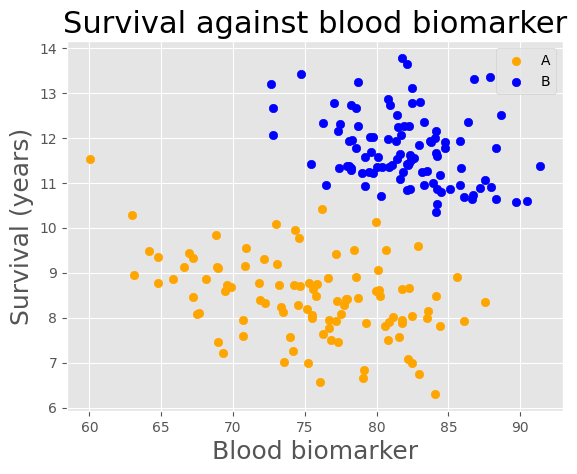

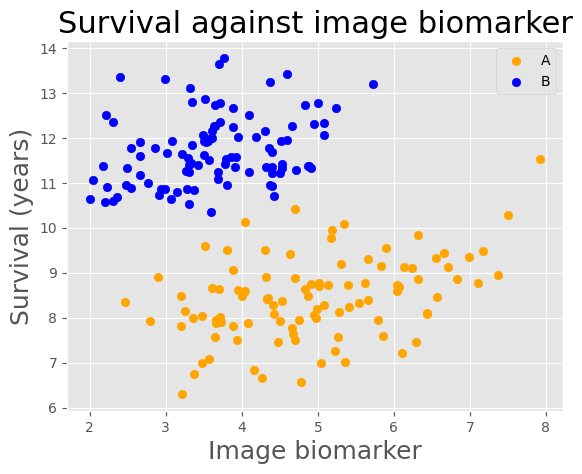

In [64]:
# seed random number generator to get consistent results
rng = np.random.default_rng(seed=11)

# function for a noisy straight line
def strt_line(x, intcp, slope):
    y = intcp + slope*(x + rng.uniform(-3, 3, size=[len(x),]))
    return y

# blood data
blood_intcp_a = 100
blood_slope_a = -3
blood_a = strt_line(survival_a, blood_intcp_a, blood_slope_a)
blood_intcp_b = 100
blood_slope_b = -1.5
blood_b = strt_line(survival_b, blood_intcp_b, blood_slope_b)

# add uniform noise to these data
blood_a = blood_a + rng.uniform(-5, 5, size=[100,])
blood_b = blood_b + rng.uniform(-5, 5, size=[100,])

# image data + noise
image_a = (((blood_a*-1)*0.2)+20) + rng.uniform(-0.1, 0.1, size=[100,])
image_b = (((blood_b*-1)*0.2)+20) + rng.uniform(-0.5, 0.5, size=[100,])

# concatenate the data for later
blood = np.concatenate((blood_a, blood_b))
image = np.concatenate((image_a, image_b))

# plot the blood data
plt.scatter(blood_a, survival_a, color='orange')
plt.scatter(blood_b, survival_b, color='blue')
plt.title("Survival against blood biomarker", fontsize = 22)
plt.legend(labels=['A', 'B'])
plt.xlabel("Blood biomarker", fontsize=18)
plt.ylabel("Survival (years)", fontsize=18)
plt.show()

# plot the image data
plt.scatter(image_a, survival_a, color='orange')
plt.scatter(image_b, survival_b, color='blue')
plt.title("Survival against image biomarker", fontsize = 22)
plt.legend(labels=['A', 'B'])
plt.xlabel("Image biomarker", fontsize=18)
plt.ylabel("Survival (years)", fontsize=18)
plt.show()

# Age data
The idea for the age data is that it is not informative, or rather, has no effect on survival. It is sampled from a uniform distribution, and plotted against survival.

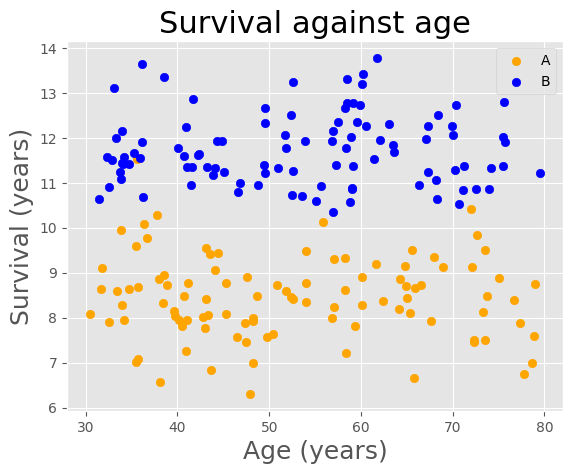

In [65]:
# generate age data from a uniform distribution (rng is defined in code cell above).
age = rng.uniform(30, 80, size=[200,])

# plot age
# note: I am repeating plot calls because I cannot remember quickly enough how to colour-code based on a variable...
plt.scatter(age[0:100], survival_a, color='orange')
plt.scatter(age[100:], survival_b, color='blue') 
plt.title("Survival against age", fontsize = 22)
plt.legend(labels=['A', 'B'])
plt.xlabel("Age (years)", fontsize=18)
plt.ylabel("Survival (years)", fontsize=18)
plt.show()

# Put the data together in a dataframe
Here, to help keep everything organised during the subsequent analysis, I will store the data in a dataframe, and call it... data. I print out the some of the first rows of each group as a demonstration of what the thing looks like, and also can print out the summary statistics here, for each column.  

In [66]:
# make the dataframe
data = pd.DataFrame({'groups':groups, 'survival':survival, 'blood':blood, 'image':image, 'age':age})

# change group type to Boolean
data['groups'] = data['groups'].astype('bool')

# print information about the data
print(data.head(105)) # some rows
print(data.describe()) # some summary statistics
print(data.dtypes) # data types

     groups   survival      blood     image        age
0     False   7.883988  81.746487  3.665978  77.316891
1     False   8.687215  69.860979  6.064178  35.749380
2     False   8.290727  74.494177  5.078194  33.965984
3     False   8.146396  83.593336  3.249989  39.585663
4     False   7.946871  81.780443  3.658999  41.028930
..      ...        ...        ...       ...        ...
100    True  10.853311  82.343237  3.279464  72.577135
101    True  10.877667  87.183545  2.540315  58.978007
102    True  13.417424  74.757503  4.594090  60.272347
103    True  12.660788  72.749929  5.237893  49.501061
104    True  12.740089  78.221606  4.836646  70.401297

[105 rows x 5 columns]
         survival       blood       image         age
count  200.000000  200.000000  200.000000  200.000000
mean    10.084828   78.682045    4.280444   52.872587
std      1.855207    5.966055    1.210288   13.694445
min      6.303210   60.006743    1.997689   30.416684
25%      8.440828   75.382567    3.472650   41

# Check for multicollinearity
This is where we uncover that our two biomarkers are correlated. The plot of correlation below shows that there is almost perfect negative correlation between the blood and image biomarkers. Note that age, as expected, does not correlate to any great extent with anything, and that survival, surprise, correlates with group. The image and blood biomarkers also show some correlation with group, which is not a massive surprise, given how they were generated. 

We do not want to include highly correlated independent variables in the regression, so here, we will exclude the blood biomarker. There also doesn't seem a great deal of point continuing with the age data, so we will not use that in the regression.

If this were a real study, then I suppose we might comment on the fact that the new image biomarker could be used as a proxy to the blood biomarker, or whichever was less invasive, or something along those lines. The point being that the correlation between the blood and image biomarker at least supports the notion that the image biomarker might be useful, and that that relationship might be worth investigating more in the future. 

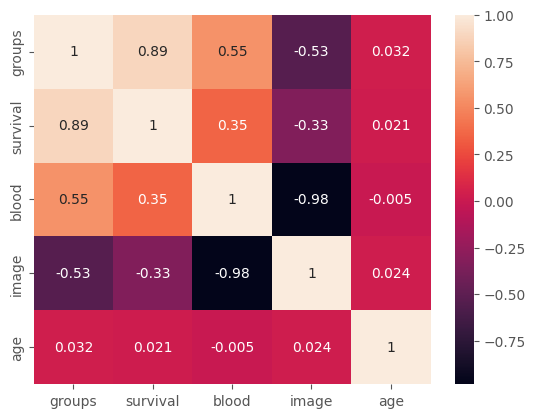

In [67]:
# get the correlation
var_corr = data.corr()

# plot the heatmap
sns.heatmap(var_corr, xticklabels=var_corr.columns, yticklabels=var_corr.columns, annot=True)
plt.show()

# Run a regression
Note that, as discussed above, I would have liked to do an inspection of the residuals after this initial regression model, but I will stick to time, and so I will finish here with an examination of a multiple linear regression.

The R-squared value is a good place to start: at 0.819 (and 0.816 for the adjusted value), the model can explain 81.9% of the variance. And with a high F-statistic, the p-value for the model overall is essentially zero, so we can reject the null hypothesis that there is no relationship between group, i.e., drug treatment, and survival, and also for the image biomarker and survival. These points are demonstrated further for the p-values for each of these independent variables: both are reported as zero. Thus, we can conclude that there is a significant relationship between the drug treatment and survival, and for the image biomarker and survival. 

As discussed, I had aimed to simulate an interaction between the biomarkers and the groups, but here, the reported p-value is 0.763, so we cannot say there is an interaction here. I would like to return to the data generation step and investigate further how I can simulate an interaction successfully. Further work is discussed in the final cell, below. 

The reported skew value is slightly high, but not too high, I think, and nor is the kurtosis. In the future, it'd be good to investigate the effect of the skewed survival data more — again, see the last cell for a short discussion of what I would do next.

In [68]:
# make a model to predict survival based on groups, image biomarker, and an interaction between those two.
model = sm.OLS.from_formula('survival ~ groups + image + groups:image', data=data).fit()

# print a summary of the model
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               survival   R-squared:                       0.819
Model:                            OLS   Adj. R-squared:                  0.816
Method:                 Least Squares   F-statistic:                     295.6
Date:                Wed, 10 Apr 2024   Prob (F-statistic):           1.82e-72
Time:                        15:51:11   Log-Likelihood:                -235.96
No. Observations:                 200   AIC:                             479.9
Df Residuals:                     196   BIC:                             493.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                6.8868      0.341     20.185      0.000       6.214       7.560
groups[T.True]           3.8272      0.494      7.743      0.000       2.852       4.802
image                    0.3151      0.067      4.679      0.000       0.182       0.448
groups[T.True]:image    -0.0355      0.117     -0.302      0.763      -0.267       0.196
==============================================================================
Omnibus:                        5.534   Durbin-Watson:                   1.976
Prob(Omnibus):                  0.063   Jarque-Bera (JB):                5.289
Skew:                           0.393   Prob(JB):                       0.0710
Kurtosis:                       3.126   Cond. No.                         49.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Further work
It is a shame to stop. For further work, I would:
- Experiment a bit more with generating data that would better demonstrate various subtleties of this analysis, such as the aimed-for interaction.
- Plot the residuals! And investigate the effect of a skewed dependent variable on the residuals of the regression. If the residuals looked not normally distributed or heteroscedastic, I could try a log transformation. 
- Plot the regression line!
- Test alternative models, for example using the other biomarker, and comparing them.

Thanks for taking the time to go through this analysis!